# ISIDORA

When a man rides a long time through wild regions he feels the desire for a city. Finally he comes to Isidora, a city where the buildings have spiral staircases encrusted with spiral seashells, where perfect telescopes and violins are made, where the foreigner hesitating between two women always encounters a third, where cockfights degenerate into bloody brawls among the bettors. He was thinking of all these things when he desired a city. Isidora, therefore, is the city of his dreams: with one difference. The dreamed-of city contained him as a young man; he arrives at Isidora in his old age. In the square there is the wall where the old men sit and watch the young go by; he is seated in a row with them. Desires are already memories.

In [2]:
from __future__ import print_function
from IPython.display import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


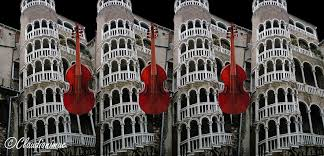

In [3]:
Image(filename='../Images/Isidora.jpg') 

1. reads the NEXT HDF5 DST (Nh5)
2. Creates Panda DF to describe the PMT and SiPM metadata
3. Creates a Panda DF to store the energy (in PES) of each PMT for each event
4. Simulates response of the EP FEE and decimates waveforms according to DAQ
5. Writes a new Nh5 DST

In [5]:
import pandas as pd
import tables as tb
import numpy as np

In [210]:
from system_of_units import *

In [218]:
from PlotUtil import *

In [211]:
def fill_data_(row):
    data ={}
    pos = row['position']
    data['channel'] =row['channel']
    data['x']= pos[0]
    data['y'] =pos[1]
    return data

def read_data_geom(pfile):
    """
    reads the geometry and return data frames
    """
    with tb.open_file(pfile, "r") as h5in:
        geom_t = h5in.root.Detector.DetectorGeometry
    
        G=[]
        for i, row in enumerate(geom_t):
            G.append(row['x_det'][0])
            G.append(row['x_det'][1])
            G.append(row['y_det'][0])
            G.append(row['y_det'][1])
            G.append(row['z_det'][0])
            G.append(row['z_det'][1])
            G.append(row['r_det'])
        
    return pd.Series(G, index=['xmin','xmax','ymin','ymax','zmin','zmax','r'])


def read_data_sensors(pfile):
    """
    reads the PMT and SIPM metadata and return data frames
    """
    with tb.open_file(pfile, "r") as h5in:
        #geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        PMT={}
        SIPM={}
        i=0
        for row in pmt_t.iterrows():
            PMT[i]=fill_data_(row)
            i+=1
        i=0
        for row in sipm_t.iterrows():
            SIPM[i]=fill_data_(row)
            i+=1
    return pd.DataFrame(PMT),pd.DataFrame(SIPM)


In [191]:
def pmt_energy_pes(pfile, nevents=1):
    """
    Creates a DF for the PMTs with the energy of each sensor in PES
    """
    with tb.open_file(pfile, "r") as h5in:
        
        pmtrd_ = h5in.root.pmtrd #pointer to the EARRAY holding the data
        print("pmtrd_ shape = {}".format(pmtrd_.shape))
        
        nev = min(nevents,pmtrd_.shape[0])
        npmt = pmtrd_.shape[1]
        print("number of PMTs = {}".format(npmt))
        print("running over {} events".format(nev))
        
        ene_pes = np.zeros((nevents,npmt))
        print("shape of ene_pes ={}".format(ene_pes.shape))
        for i in range(nev):
            for j in range(npmt):
                pmtrd = pmtrd_[i, j]
                ene = sum(pmtrd)
                ene_pes[i,j] = ene
            
         
    return pd.DataFrame(ene_pes)

In [192]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/'
%ls /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/

1ns/               WF_Kr_0.h5         WF_Tl_1100evts.h5
25ns/              WF_Na_0.h5         root/
NA-zlib/           WF_Tl_0.h5         test.h5


In [197]:
ffile='WF_Tl_0.h5'

In [198]:
g = read_data_geom(path+ffile)

In [106]:
g

xmin   -198.0
xmax    198.0
ymin   -198.0
ymax    198.0
zmin      0.0
zmax    532.0
r       198.0
dtype: float64

In [199]:
pmtdf,sipmdf =read_data_sensors(path+ffile)

In [200]:
pmtdf

,0,1,2,3,4,5,6,7,8,9,10,11
channel,0.0000,1.0000,2.0000,3.0,5.000,6.0000,8.000,9.0000,10.0000,12.000,13.0000,14.000
x,23.9414,-68.9365,44.9951,0.0,-118.916,-182.1890,-160.215,-63.2737,63.2737,160.215,182.1890,118.916
y,65.7785,-12.1554,-53.6231,185.0,141.718,32.1249,-92.500,-173.8430,-173.8430,-92.500,32.1249,141.718


In [201]:
sipmdf

,0,1,2,3,4,5,6,7,8,9,...,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790
channel,1001.0,1002.0,1003.0,1004.0,1005.0,1006.0,1007.0,1008.0,1009.0,1010.0,...,28054.0,28055.0,28056.0,28057.0,28058.0,28059.0,28060.0,28061.0,28062.0,28063.0
x,235.0,235.0,235.0,235.0,235.0,235.0,235.0,225.0,225.0,225.0,...,-225.0,-225.0,-235.0,-235.0,-235.0,-235.0,-235.0,-235.0,-235.0,-235.0
y,55.0,65.0,75.0,85.0,95.0,105.0,115.0,45.0,55.0,65.0,...,-55.0,-45.0,-115.0,-105.0,-95.0,-85.0,-75.0,-65.0,-55.0,-45.0


In [204]:
enedf = pmt_energy_pes(path+ffile,100)

pmtrd_ shape = (99, 12, 599999)
number of PMTs = 12
running over 99 events
shape of ene_pes =(100, 12)


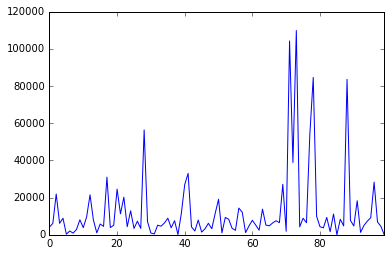

In [205]:
enedf[0].plot()

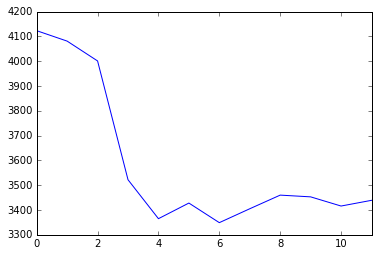

In [206]:
enedf.ix[0].plot()

## Simulation of EP FEE

In [213]:
def simulate_PMT(pfile,nevents=1):
    """
    Simulate the response of the EP
    """
    import FEParam as FP
    import SPE as SP
    import FEE2 as FE
    
    signal_t = np.arange(0.0, 599999., 1., dtype=np.float64)

    with tb.open_file(pfile, "r") as h5in:
        pmtrd_ = h5in.root.pmtrd
        print("pmtrd_ shape = {}".format(pmtrd_.shape))
        
        nev = min(nevents,pmtrd_.shape[0])
        npmt = pmtrd_.shape[1]
        
        print("number of PMTs = {}".format(npmt))
        print("running over {} events".format(nev))
        PMT={}
        for i in range(nev):
            rdata =[]
            for j in range(npmt):
                print("pmt number = {}".format(j))
                pmtrd = pmtrd_[i, j]
                fee = FE.FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN) 
                spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)
                signal_PMT = spe.SpePulseFromVectorPE(pmtrd)
                signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE) 
                signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
                rdata.append(signal_daq)
            PMT[i]= rdata
        return PMT
            
       

In [216]:
pmtwf = simulate_PMT(path+ffile,nevents=1)

pmtrd_ shape = (99, 12, 599999)
number of PMTs = 12
running over 1 events
pmt number = 0
pmt number = 1
pmt number = 2
pmt number = 3
pmt number = 4
pmt number = 5
pmt number = 6
pmt number = 7
pmt number = 8
pmt number = 9
pmt number = 10
pmt number = 11


In [223]:
def plot_waveforms(pmtwf, indx=0):
    pmt = pmtwf[indx]
    
    plt.figure(figsize=(12,12))
    
    len_pmt = len(pmt[0])
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len_pmt])
        SetPlotLabels(xlabel='t (ns)', ylabel='adc')
        plt.plot(pmt[i])

    
    plt.show()

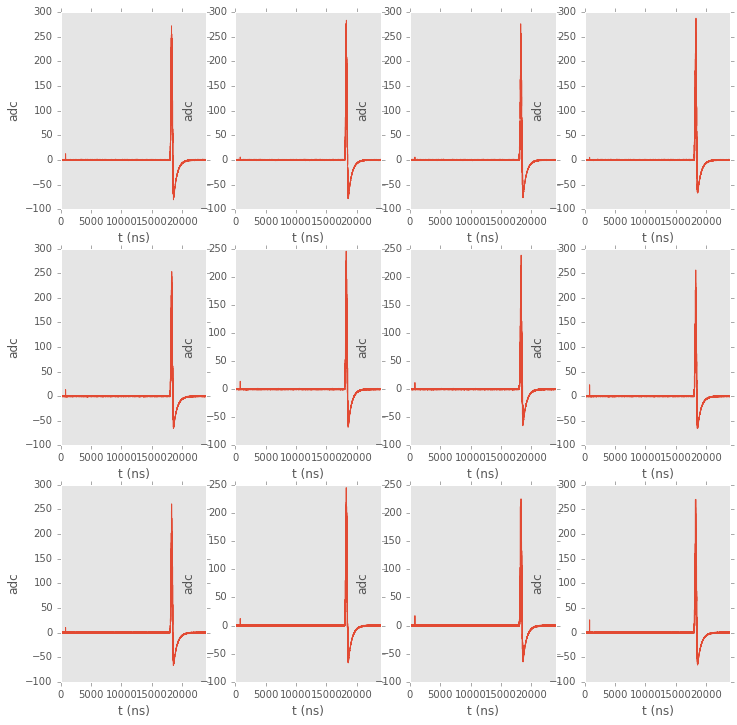

In [224]:
plot_waveforms(pmtwf, indx=0)

In [233]:
def read_Nh5Dst_PMT(pfile,nevents=1):
    """
    Read the PMTs
    """

    with tb.open_file(pfile, "r") as h5in:
        print(h5in)
        pmtrd_ = h5in.root.pmtrd
        print("pmtrd_ shape = {}".format(pmtrd_.shape))
        nev = min(nevents,pmtrd_.shape[0])
        npmt = pmtrd_.shape[1]
        
        print("number of PMTs = {}".format(npmt))
        print("running over {} events".format(nev))
        PMT={}
        for i in range(nev):
            rdata =[]
            for j in range(npmt):
                print("pmt number = {}".format(j))
                rdata.append(pmtrd_[i, j])
            PMT[i]= rdata
        return PMT
        

In [226]:
path="/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/"

In [227]:
ffile="WF_Tl_0.h5"

In [234]:
pmtwf2 = read_Nh5Dst_PMT(path+ffile,nevents=1)

/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Tl_0.h5 (File) ''
Last modif.: 'Tue Aug  9 19:37:52 2016'
Object Tree: 
/ (RootGroup) ''
/pmtrd (EArray(10, 12, 24000), shuffle, blosc(9)) ''
/sipmrd (EArray(10, 1792, 600), shuffle, blosc(9)) ''
/SimulationParameters (Group) ''
/SimulationParameters/FEE (Table(1,)) 'SimulationParameters'

pmtrd_ shape = (10, 12, 24000)
number of PMTs = 12
running over 1 events
pmt number = 0
pmt number = 1
pmt number = 2
pmt number = 3
pmt number = 4
pmt number = 5
pmt number = 6
pmt number = 7
pmt number = 8
pmt number = 9
pmt number = 10
pmt number = 11


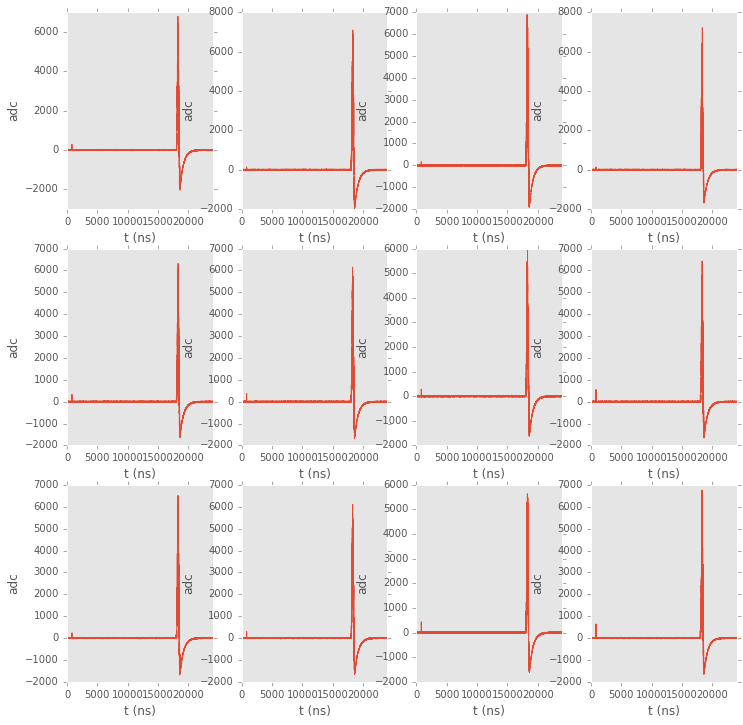

In [235]:
plot_waveforms(pmtwf2, indx=0)

In [246]:
def read_Nh5Dst_SiPM(pfile,nevents=1):
    """
    read the SiPM
    """
    
    with tb.open_file(pfile, "r") as h5in:
        print(h5in)
        pmtrd_ = h5in.root.sipmrd
        print("sipmrd_ shape = {}".format(pmtrd_.shape))
        nev = min(nevents,pmtrd_.shape[0])
        npmt = pmtrd_.shape[1]
        
        print("number of SiPMs = {}".format(npmt))
        print("running over {} events".format(nev))
        PMT={}
        for i in range(nev):
            rdata =[]
            for j in range(npmt):
                rdata.append(pmtrd_[i, j])
            PMT[i]= rdata
        return PMT

In [247]:
sipmwf2 = read_Nh5Dst_SiPM(path+ffile,nevents=1)

/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Tl_0.h5 (File) ''
Last modif.: 'Tue Aug  9 19:37:52 2016'
Object Tree: 
/ (RootGroup) ''
/pmtrd (EArray(10, 12, 24000), shuffle, blosc(9)) ''
/sipmrd (EArray(10, 1792, 600), shuffle, blosc(9)) ''
/SimulationParameters (Group) ''
/SimulationParameters/FEE (Table(1,)) 'SimulationParameters'

sipmrd_ shape = (10, 1792, 600)
number of SiPMs = 1792
running over 1 events


In [250]:
def sipm_energy(sipmwf, indx=0):
    """
    returns an array with the energy of the SiPMs
    """
    sipm_WFS = sipmwf[indx]
    
    energy=[]
    for i in range(len(sipm_WFS)):
        sipm_wf = sipm_WFS[i]
        energy.append(np.sum(sipm_wf))
    return pd.Series(energy)

In [251]:
eneSiPM = sipm_energy(sipmwf2, indx=0)

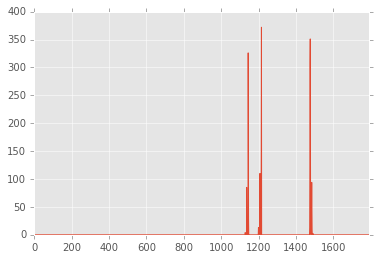

In [252]:
eneSiPM.plot()